Fetching data for all instruments...

Testing for cointegration on TRAIN set...

                  pair   p_value  cointegrated
12  GBP_USD vs NZD_USD  0.025729          True
59  EUR_GBP vs CAD_JPY  0.035440          True
58  EUR_GBP vs AUD_JPY  0.043939          True
56  EUR_GBP vs EUR_JPY  0.049634          True

--- Strategy Performance on TEST SET: GBP_USD vs NZD_USD ---
Total Profit: 0.9461
Number of Trades: 29
Win Rate: 65.52%
Avg Profit per Trade: 0.0326
Max Drawdown: nan


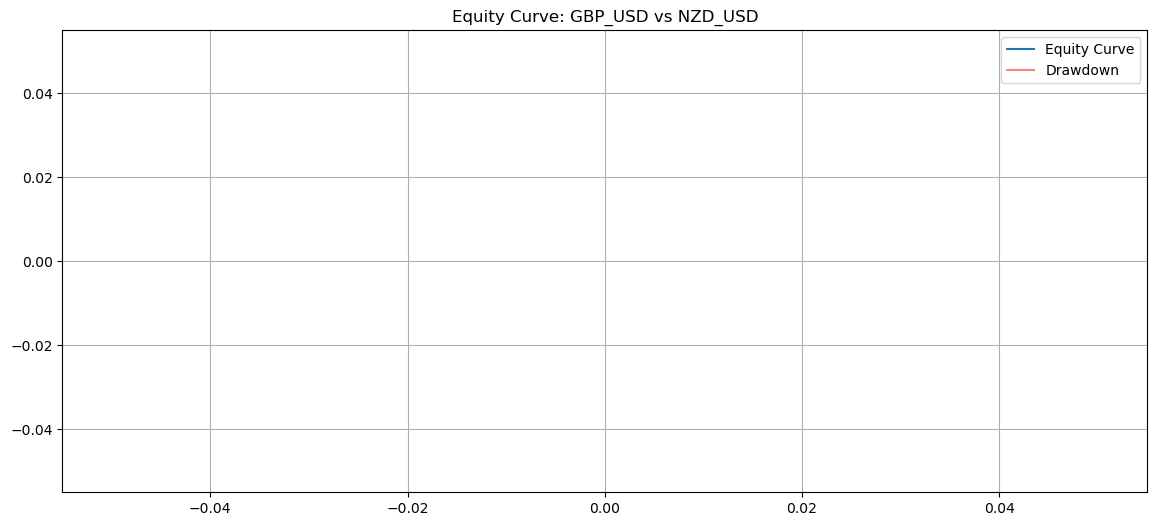


--- Strategy Performance on TEST SET: EUR_GBP vs CAD_JPY ---
Total Profit: -0.0726
Number of Trades: 45
Win Rate: 2.22%
Avg Profit per Trade: -0.0016
Max Drawdown: nan


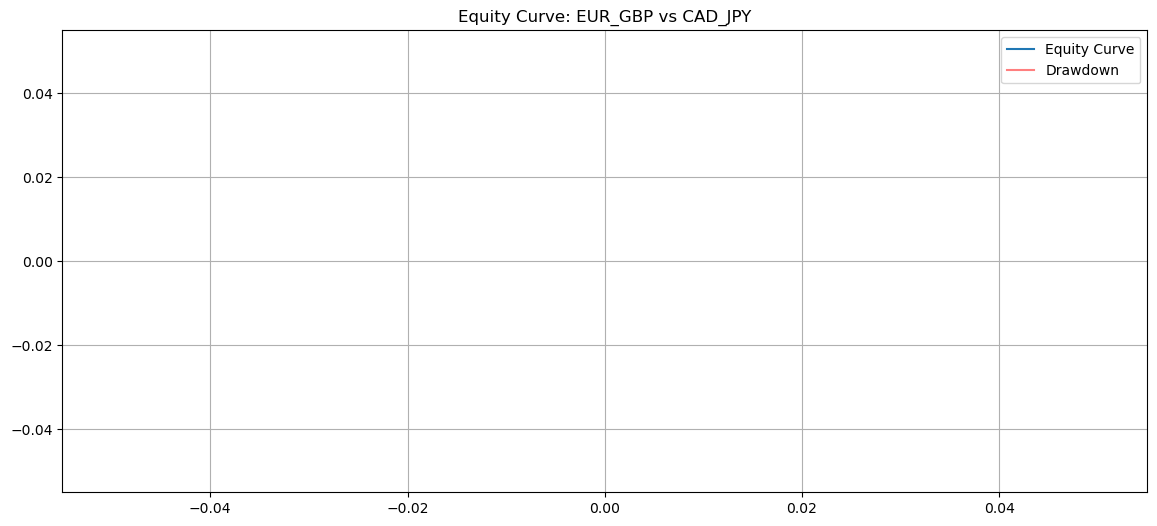


--- Strategy Performance on TEST SET: EUR_GBP vs AUD_JPY ---
Total Profit: -0.0645
Number of Trades: 50
Win Rate: 4.00%
Avg Profit per Trade: -0.0013
Max Drawdown: nan


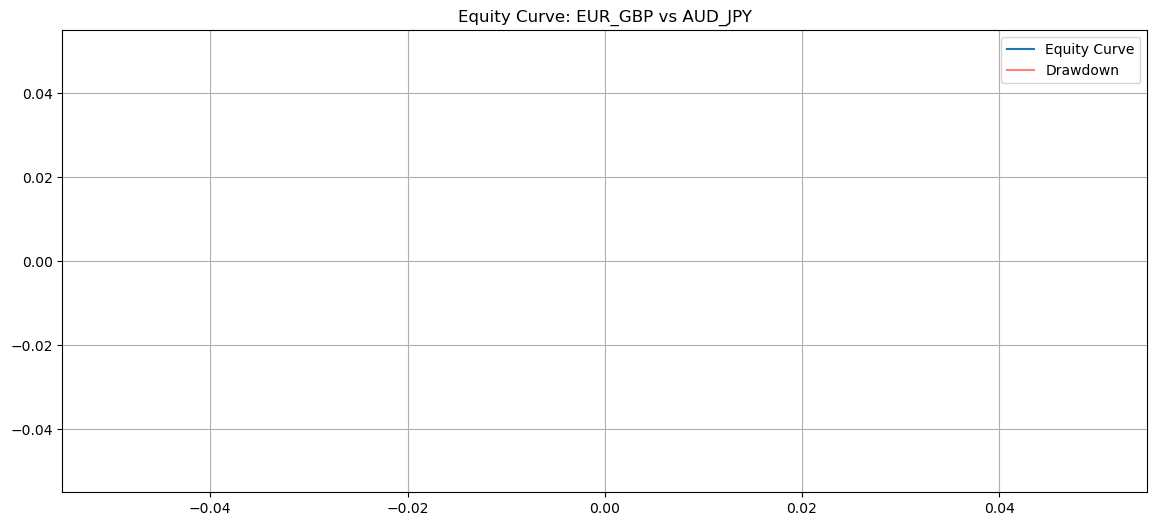


--- Strategy Performance on TEST SET: EUR_GBP vs EUR_JPY ---
Total Profit: -0.1285
Number of Trades: 52
Win Rate: 0.00%
Avg Profit per Trade: -0.0025
Max Drawdown: nan


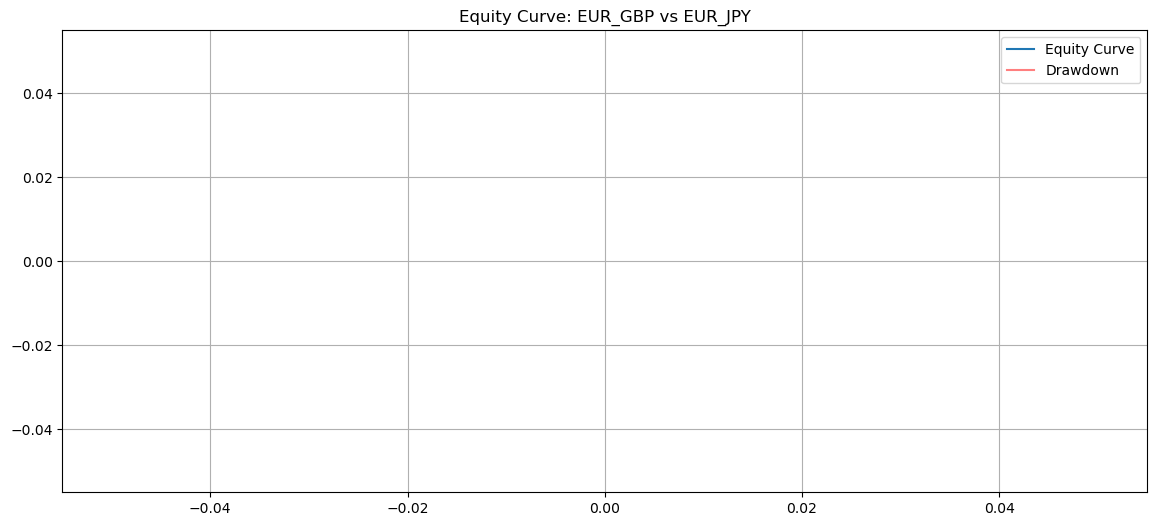

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
from statsmodels.tsa.stattools import coint
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# --- OANDA API ---
ACCESS_TOKEN = "32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693"
CLIENT = API(access_token=ACCESS_TOKEN, environment="practice")

INSTRUMENTS = [
    "EUR_USD", "GBP_USD", "AUD_USD", "NZD_USD",
    "USD_CAD", "USD_CHF", "USD_JPY", "EUR_GBP",
    "EUR_JPY", "GBP_JPY", "AUD_JPY", "CAD_JPY"
]

def fetch_data(instrument, granularity="D", count=1800):
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    try:
        CLIENT.request(r)
    except Exception as e:
        print(f"Failed to fetch {instrument}: {e}")
        return None
    data = []
    for candle in r.response['candles']:
        data.append({
            'datetime': pd.to_datetime(candle['time']),
            'close': float(candle['mid']['c'])
        })
    df = pd.DataFrame(data)
    df.set_index('datetime', inplace=True)
    df.columns = [instrument]
    return df

print("Fetching data for all instruments...")
dfs = {}
for inst in INSTRUMENTS:
    df = fetch_data(inst)
    if df is not None:
        dfs[inst] = df

price_df = pd.concat(dfs.values(), axis=1, join='inner')
train_size = int(0.7 * len(price_df))
train_df = price_df.iloc[:train_size]
test_df = price_df.iloc[train_size:]

# --- Cointegration ---
print("\nTesting for cointegration on TRAIN set...\n")
results = []
for i, col1 in enumerate(train_df.columns):
    for j, col2 in enumerate(train_df.columns):
        if i >= j: continue
        y, x = train_df[col1], train_df[col2]
        score, pval, _ = coint(y, x)
        results.append({'pair': f"{col1} vs {col2}", 'p_value': pval, 'cointegrated': pval < 0.05})

result_df = pd.DataFrame(results).sort_values(by='p_value')
cointegrated_df = result_df[result_df['cointegrated']]
print(cointegrated_df)

# --- Kalman Regression ---
def online_kalman(y, x):
    x_array = np.array(x).reshape(-1, 1)
    y_array = np.array(y)
    kf = KalmanFilter(
        transition_matrices=np.eye(1),
        observation_covariance=1e-3,
        transition_covariance=np.eye(1) * 1e-5,
        initial_state_mean=0,
        initial_state_covariance=np.eye(1)
    )
    state_means = []
    state, cov = kf.initial_state_mean, kf.initial_state_covariance
    for i in range(len(y_array)):
        obs_matrix = x_array[i].reshape(1, 1)
        state, cov = kf.filter_update(state, cov, observation=y_array[i], observation_matrix=obs_matrix)
        state_means.append(state[0])
    return pd.Series(state_means, index=y.index)

# --- Test all cointegrated pairs ---
for _, row in cointegrated_df.iterrows():
    y_name, x_name = row['pair'].split(" vs ")
    if y_name not in price_df.columns or x_name not in price_df.columns:
        continue

    y, x = price_df[y_name], price_df[x_name]
    hedge_ratio = online_kalman(y, x)
    spread = y - hedge_ratio * x

    WINDOW = 20
    spread_mean = spread.rolling(WINDOW).mean()
    spread_std = spread.rolling(WINDOW).std()
    upper = spread_mean + 1.5 * spread_std
    lower = spread_mean - 1.5 * spread_std

    df = pd.DataFrame({'y': y, 'x': x, 'spread': spread, 'hr': hedge_ratio,
                       'mean': spread_mean, 'upper': upper, 'lower': lower})
    df_test = df.iloc[train_size:].copy()

    df_test['long_entry'] = (df_test['spread'] < df_test['lower']) & (df_test['spread'].shift(1) > df_test['lower'])
    df_test['short_entry'] = (df_test['spread'] > df_test['upper']) & (df_test['spread'].shift(1) < df_test['upper'])
    df_test['exit'] = ((df_test['spread'] < df_test['mean']) & (df_test['spread'].shift(1) > df_test['mean'])) | \
                      ((df_test['spread'] > df_test['mean']) & (df_test['spread'].shift(1) < df_test['mean']))

    position, entry_spread, entry_time = None, None, None
    trades = []
    for idx, row in df_test.iterrows():
        if position is None:
            if row['long_entry']:
                position = 'long'
                entry_spread = row['spread']
                entry_time = idx
            elif row['short_entry']:
                position = 'short'
                entry_spread = row['spread']
                entry_time = idx
        elif row['exit']:
            exit_spread = row['spread']
            profit = (exit_spread - entry_spread) if position == 'long' else (entry_spread - exit_spread)
            profit -= 0.0003
            trades.append({'entry_time': entry_time, 'exit_time': idx, 'position': position, 'profit': profit})
            position = None

    trade_df = pd.DataFrame(trades)
    print(f"\n--- Strategy Performance on TEST SET: {y_name} vs {x_name} ---")
    if not trade_df.empty:
        LEVERAGE = 10
        trade_df['profit'] *= LEVERAGE
        trade_df['equity'] = trade_df['profit'].cumsum()
        trade_df['equity'] = pd.to_numeric(trade_df['equity'], errors='coerce')
        trade_df['running_max'] = trade_df['equity'].cummax()
        trade_df['drawdown'] = trade_df['running_max'] - trade_df['equity']

        print(f"Total Profit: {float(trade_df['profit'].sum()):.4f}")
        print(f"Number of Trades: {len(trade_df)}")
        print(f"Win Rate: {(trade_df['profit'] > 0).mean() * 100:.2f}%")
        print(f"Avg Profit per Trade: {float(trade_df['profit'].mean()):.4f}")
        print(f"Max Drawdown: {float(trade_df['drawdown'].max()):.4f}")

        plt.figure(figsize=(14, 6))
        plt.plot(trade_df['equity'], label='Equity Curve')
        plt.plot(-trade_df['drawdown'], label='Drawdown', color='red', alpha=0.5)
        plt.title(f"Equity Curve: {y_name} vs {x_name}")
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("No trades executed on test set.")


In [4]:
# --- Imports ---
import pandas as pd
import numpy as np
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

# --- API ---
ACCESS_TOKEN = "32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693"
CLIENT = API(access_token=ACCESS_TOKEN, environment="practice")

INSTRUMENTS = [
    "EUR_USD", "GBP_USD", "AUD_USD", "NZD_USD",
    "USD_CAD", "USD_CHF", "USD_JPY", "EUR_GBP",
    "EUR_JPY", "GBP_JPY", "AUD_JPY", "CAD_JPY"
]

def fetch_data(instrument, granularity="D", count=1800):
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    try:
        CLIENT.request(r)
    except Exception as e:
        print(f"Failed to fetch {instrument}: {e}")
        return None
    data = [{
        'datetime': pd.to_datetime(candle['time']),
        instrument: float(candle['mid']['c'])
    } for candle in r.response['candles']]
    df = pd.DataFrame(data).set_index('datetime')
    return df

print("Fetching data for all instruments...")
dfs = {inst: fetch_data(inst) for inst in INSTRUMENTS}
price_df = pd.concat([df for df in dfs.values() if df is not None], axis=1, join='inner')

train_size = int(len(price_df) * 0.7)
train_df = price_df.iloc[:train_size]
test_df = price_df.iloc[train_size:]

# --- Cointegration test sur TRAIN ---
print("\nTesting for cointegration on TRAIN set...\n")
results = []
for i, col1 in enumerate(train_df.columns):
    for j, col2 in enumerate(train_df.columns):
        if i >= j: continue
        pval = coint(train_df[col1], train_df[col2])[1]
        results.append({'pair': f"{col1} vs {col2}", 'p_value': pval, 'cointegrated': pval < 0.05})

cointegrated_df = pd.DataFrame(results).sort_values(by='p_value')
print(cointegrated_df[cointegrated_df['cointegrated']])

# --- Strategy loop over cointegrated pairs ---
WINDOW = 30
PROFIT_FILTER = 0.001
LEVERAGE = 10

for _, row in cointegrated_df.iterrows():
    if not row['cointegrated']: continue
    y_name, x_name = row['pair'].split(" vs ")
    if y_name not in price_df or x_name not in price_df: continue

    y_all, x_all = price_df[y_name], price_df[x_name]
    y_train, x_train = y_all.iloc[:train_size], x_all.iloc[:train_size]
    y_test, x_test = y_all.iloc[train_size:], x_all.iloc[train_size:]

    # --- Re-test cointegration sur TEST
    pval_test = coint(y_test, x_test)[1]
    if pval_test >= 0.05:
        print(f"\n{y_name} vs {x_name} NOT cointegrated on TEST (p={pval_test:.4f}), skipped.")
        continue

    # --- Hedge ratio constant (OLS sur train)
    model = OLS(y_train, add_constant(x_train)).fit()
    beta = model.params[1]
    const = model.params[0]

    spread_test = y_test - (beta * x_test + const)
    spread_mean = spread_test.rolling(WINDOW).mean()
    spread_std = spread_test.rolling(WINDOW).std()
    upper = spread_mean + 1.5 * spread_std
    lower = spread_mean - 1.5 * spread_std

    df = pd.DataFrame({
        'spread': spread_test,
        'mean': spread_mean,
        'upper': upper,
        'lower': lower
    })

    df['long_entry'] = (df['spread'] < df['lower']) & (df['spread'].shift(1) >= df['lower'])
    df['short_entry'] = (df['spread'] > df['upper']) & (df['spread'].shift(1) <= df['upper'])
    df['exit'] = ((df['spread'] < df['mean']) & (df['spread'].shift(1) > df['mean'])) | \
                 ((df['spread'] > df['mean']) & (df['spread'].shift(1) < df['mean']))

    trades = []
    position, entry_spread, entry_time = None, None, None
    for idx, r in df.iterrows():
        if position is None:
            if r['long_entry'] and abs(r['spread'] - r['mean']) > PROFIT_FILTER:
                position = 'long'
                entry_spread = r['spread']
                entry_time = idx
            elif r['short_entry'] and abs(r['spread'] - r['mean']) > PROFIT_FILTER:
                position = 'short'
                entry_spread = r['spread']
                entry_time = idx
        elif r['exit']:
            exit_spread = r['spread']
            profit = (exit_spread - entry_spread) if position == 'long' else (entry_spread - exit_spread)
            profit -= 0.0003
            trades.append({'entry_time': entry_time, 'exit_time': idx, 'profit': profit * LEVERAGE})
            position = None

    trade_df = pd.DataFrame(trades)
    print(f"\n--- Strategy Performance on TEST SET: {y_name} vs {x_name} ---")
    if not trade_df.empty:
        trade_df['equity'] = trade_df['profit'].cumsum()
        trade_df['running_max'] = trade_df['equity'].cummax()
        trade_df['drawdown'] = trade_df['running_max'] - trade_df['equity']

        print(f"Total Profit: {trade_df['profit'].sum():.4f}")
        print(f"Number of Trades: {len(trade_df)}")
        print(f"Win Rate: {(trade_df['profit'] > 0).mean() * 100:.2f}%")
        print(f"Avg Profit per Trade: {trade_df['profit'].mean():.4f}")
        print(f"Max Drawdown: {trade_df['drawdown'].max():.4f}")

        plt.figure(figsize=(14, 6))
        plt.plot(trade_df['equity'], label='Equity Curve')
        plt.plot(-trade_df['drawdown'], label='Drawdown', color='red', alpha=0.5)
        plt.title(f"Equity Curve: {y_name} vs {x_name}")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No trades executed on test set.")

Fetching data for all instruments...

Testing for cointegration on TRAIN set...

                  pair   p_value  cointegrated
12  GBP_USD vs NZD_USD  0.025729          True
59  EUR_GBP vs CAD_JPY  0.035440          True
58  EUR_GBP vs AUD_JPY  0.043939          True
56  EUR_GBP vs EUR_JPY  0.049634          True

GBP_USD vs NZD_USD NOT cointegrated on TEST (p=0.9104), skipped.

EUR_GBP vs CAD_JPY NOT cointegrated on TEST (p=0.2343), skipped.

EUR_GBP vs AUD_JPY NOT cointegrated on TEST (p=0.3053), skipped.

EUR_GBP vs EUR_JPY NOT cointegrated on TEST (p=0.2620), skipped.


Fetching data...

--- Testing for cointegration on TRAIN set ---
                  pair   p_value  cointegrated
8   GBP_JPY vs NZD_JPY  0.005984          True
2   EUR_GBP vs CAD_JPY  0.033614          True
11  AUD_JPY vs NZD_JPY  0.039967          True
1   EUR_GBP vs AUD_JPY  0.040909          True
4   EUR_GBP vs NZD_JPY  0.041333          True
7   GBP_JPY vs EUR_JPY  0.046187          True
3   EUR_GBP vs EUR_JPY  0.046338          True

--- Analyzing Pair: GBP_JPY vs NZD_JPY ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ❌
🚫 Relationship broke down in test set. Skipping trade simulation.

--- Analyzing Pair: EUR_GBP vs CAD_JPY ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\3570262068.py:138: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')



--- Strategy Performance on TEST SET: EUR_GBP vs CAD_JPY ---
✅ Total Profit: 0.6761
📈 Number of Trades: 44
🎯 Win Rate: 68.18%
💰 Avg Profit per Trade: 0.0154
📉 Max Drawdown: 0.8055


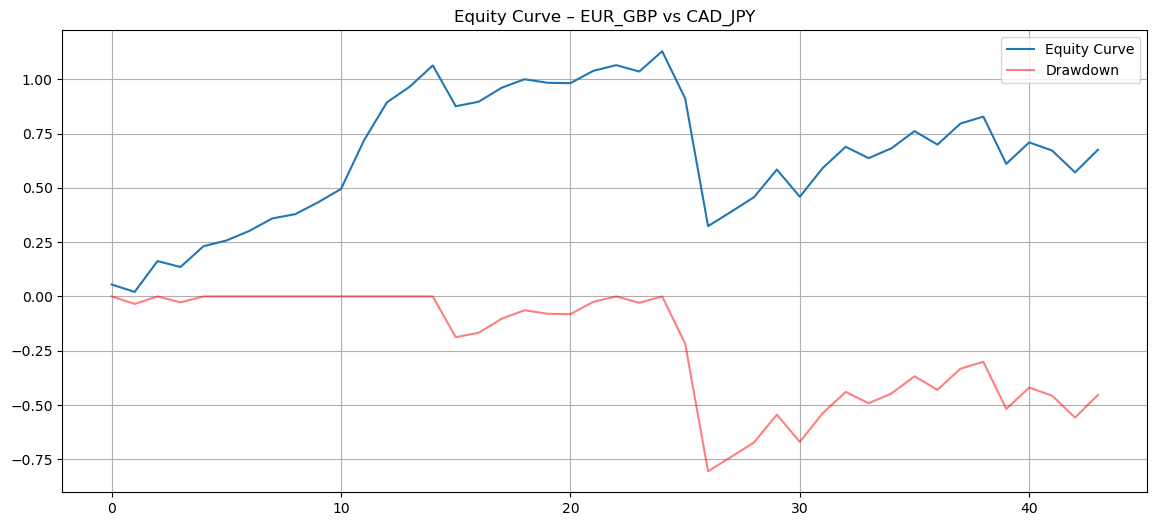


--- Analyzing Pair: AUD_JPY vs NZD_JPY ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ❌
🚫 Relationship broke down in test set. Skipping trade simulation.

--- Analyzing Pair: EUR_GBP vs AUD_JPY ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ❌
🚫 Relationship broke down in test set. Skipping trade simulation.

--- Analyzing Pair: EUR_GBP vs NZD_JPY ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ❌
🚫 Relationship broke down in test set. Skipping trade simulation.

--- Analyzing Pair: GBP_JPY vs EUR_JPY ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ❌
🚫 Relationship broke down in test set. Skipping trade simulation.

--- Analyzing Pair: EUR_GBP vs EUR_JPY ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ❌
🚫 Relationship broke down in test set. Skipping trade simulation.


In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
from statsmodels.tsa.stattools import coint, adfuller
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Set up OANDA API client
ACCESS_TOKEN = "32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693"
CLIENT = API(access_token=ACCESS_TOKEN, environment="practice")

# List of diverse forex pairs to test
INSTRUMENTS = ["EUR_GBP", "GBP_JPY", "AUD_JPY", "CAD_JPY", "EUR_JPY", "NZD_JPY"]

def fetch_data(instrument, granularity="D", count=1800):  # ~5 years of daily data
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    try:
        CLIENT.request(r)
    except Exception as e:
        print(f"Failed to fetch {instrument}: {e}")
        return None
    data = []
    for candle in r.response['candles']:
        data.append({
            'datetime': pd.to_datetime(candle['time']),
            'close': float(candle['mid']['c'])
        })
    df = pd.DataFrame(data)
    df.set_index('datetime', inplace=True)
    df.columns = [instrument]
    return df

# Step 1: Fetch data
print("Fetching data...")
dfs = {}
for inst in INSTRUMENTS:
    df = fetch_data(inst)
    if df is not None:
        dfs[inst] = df

price_df = pd.concat(dfs.values(), axis=1, join='inner')

# Step 2: Split into train/test sets
train_size = int(0.7 * len(price_df))
train_df = price_df.iloc[:train_size]
test_df = price_df.iloc[train_size:]

print("\n--- Testing for cointegration on TRAIN set ---")
results = []

for i, col1 in enumerate(train_df.columns):
    for j, col2 in enumerate(train_df.columns):
        if i >= j:
            continue
        y_train, x_train = train_df[col1], train_df[col2]
        score, pval, _ = coint(y_train, x_train)
        results.append({'pair': f"{col1} vs {col2}", 'p_value': pval, 'cointegrated': pval < 0.05})

result_df = pd.DataFrame(results).sort_values(by='p_value')
cointegrated_train_pairs = result_df[result_df['cointegrated']]
print(cointegrated_train_pairs)

# Step 3: For each cointegrated pair, backtest on train + test
ENTRY_Z = 1.0
EXIT_Z = 0.5
PIP_COST = 0.0003
WINDOW = 20
LEVERAGE = 10

def kalman_regression(y, x):
    x_array = np.array(x).reshape(-1, 1)
    y_array = np.array(y)
    observation_matrices = np.expand_dims(x_array, axis=1)

    kf = KalmanFilter(
        transition_matrices=np.array([[1]]),
        observation_matrices=observation_matrices,
        transition_covariance=np.eye(1) * 1e-5,
        observation_covariance=1e-3,
        initial_state_mean=0,
        initial_state_covariance=np.eye(1)
    )

    state_means, _ = kf.filter(y_array)
    return pd.Series(state_means.flatten(), index=x.index)

def is_stationary(spread, window=60):
    _, p_val, _, _, _, _ = adfuller(spread.dropna())
    return p_val < 0.05

# Loop through all cointegrated pairs
for _, row in cointegrated_train_pairs.iterrows():
    pair_name = row['pair']
    print(f"\n--- Analyzing Pair: {pair_name} ---")

    y_name, x_name = pair_name.split(" vs ")
    if y_name not in price_df.columns or x_name not in price_df.columns:
        print("⚠️ Columns missing in full dataset")
        continue

    y_full = price_df[y_name]
    x_full = price_df[x_name]

    y_train = train_df[y_name]
    x_train = train_df[x_name]
    y_test = test_df[y_name]
    x_test = test_df[x_name]

    # Step 4: Train Kalman filter on train set only
    hedge_ratio_train = kalman_regression(y_train, x_train)
    spread_train = y_train - hedge_ratio_train * x_train

    # Step 5: Apply same hedge ratio on test set
    last_hedge = hedge_ratio_train.iloc[-1]
    hedge_ratio_test = pd.Series(np.repeat(last_hedge, len(x_test)), index=x_test.index)
    spread_test = y_test - hedge_ratio_test * x_test

    # Step 6: Check stationarity on both train and test
    train_stationary = is_stationary(spread_train)
    test_stationary = is_stationary(spread_test)

    print(f"ADF Stationary in Train: {'✅' if train_stationary else '❌'}")
    print(f"ADF Stationary in Test:  {'✅' if test_stationary else '❌'}")

    if not test_stationary:
        print("🚫 Relationship broke down in test set. Skipping trade simulation.")
        continue

    # Step 7: Only simulate if still stationary in test
    z_score_train = (spread_train - spread_train.rolling(WINDOW).mean()) / spread_train.rolling(WINDOW).std()
    mean_z = z_score_train.mean()
    std_z = z_score_train.std()

    z_score_test = (spread_test - spread_test.rolling(WINDOW).mean()) / spread_test.rolling(WINDOW).std()
    z_score_test = z_score_test.fillna(method='ffill')

    df_test = pd.DataFrame({
        'z_score': z_score_test,
        'spread': spread_test
    })

    df_test['long_entry'] = (
        (df_test['z_score'] < -ENTRY_Z) &
        (df_test['z_score'].shift(1) > -ENTRY_Z)
    )
    df_test['short_entry'] = (
        (df_test['z_score'] > ENTRY_Z) &
        (df_test['z_score'].shift(1) < ENTRY_Z)
    )
    df_test['exit'] = (
        (df_test['z_score'] > -EXIT_Z) & (df_test['z_score'].shift(1) < -EXIT_Z) |
        (df_test['z_score'] < EXIT_Z) & (df_test['z_score'].shift(1) > EXIT_Z)
    )

    # Step 8: Simulate trades
    position = None
    trades = []

    for idx, row in df_test.iterrows():
        if position is None:
            if row['long_entry']:
                position = 'long'
                entry_spread = row['spread']
                entry_time = idx
            elif row['short_entry']:
                position = 'short'
                entry_spread = row['spread']
                entry_time = idx
        else:
            if row['exit']:
                exit_spread = row['spread']
                profit = (exit_spread - entry_spread) if position == 'long' else (entry_spread - exit_spread)
                profit -= PIP_COST
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': idx,
                    'position': position,
                    'profit': profit
                })
                position = None

    trade_df = pd.DataFrame(trades)
    print(f"\n--- Strategy Performance on TEST SET: {pair_name} ---")
    if not trade_df.empty:
        trade_df['profit'] *= LEVERAGE
        trade_df['equity'] = trade_df['profit'].cumsum()
        trade_df['drawdown'] = trade_df['equity'].cummax() - trade_df['equity']

        total_profit = trade_df['profit'].sum()
        win_rate = (trade_df['profit'] > 0).mean() * 100
        num_trades = len(trade_df)
        avg_profit = trade_df['profit'].mean()
        max_drawdown = trade_df['drawdown'].max()

        print(f"✅ Total Profit: {total_profit:.4f}")
        print(f"📈 Number of Trades: {num_trades}")
        print(f"🎯 Win Rate: {win_rate:.2f}%")
        print(f"💰 Avg Profit per Trade: {avg_profit:.4f}")
        print(f"📉 Max Drawdown: {max_drawdown:.4f}")

        plt.figure(figsize=(14, 6))
        trade_df['equity'].plot(label='Equity Curve')
        (-trade_df['drawdown']).plot(label='Drawdown', color='red', alpha=0.5)
        plt.title(f"Equity Curve – {pair_name}")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("❌ No trades executed on test set.")

Fetching data...
Failed to fetch SPX500_USD: {"errorMessage":"Maximum value for 'count' exceeded"}
⚠️ No data returned for SPX500_USD
Failed to fetch NAS100_USD: {"errorMessage":"Maximum value for 'count' exceeded"}
⚠️ No data returned for NAS100_USD
Failed to fetch DE30_EUR: {"errorMessage":"Maximum value for 'count' exceeded"}
⚠️ No data returned for DE30_EUR
Failed to fetch UK100_GBP: {"errorMessage":"Maximum value for 'count' exceeded"}
⚠️ No data returned for UK100_GBP

❌ No data fetched from OANDA. Using fallback test dataset...
✅ Created synthetic test dataset.

--- Testing for cointegration on TRAIN set ---
                       pair       p_value  cointegrated
0  SPX500_USD vs NAS100_USD  0.000000e+00          True
2   NAS100_USD vs UK100_GBP  0.000000e+00          True
1   SPX500_USD vs UK100_GBP  1.537237e-29          True

--- Analyzing Pair: SPX500_USD vs NAS100_USD ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅

--- Strategy Performance on TEST SET: SPX500_USD

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\3632898950.py:158: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')


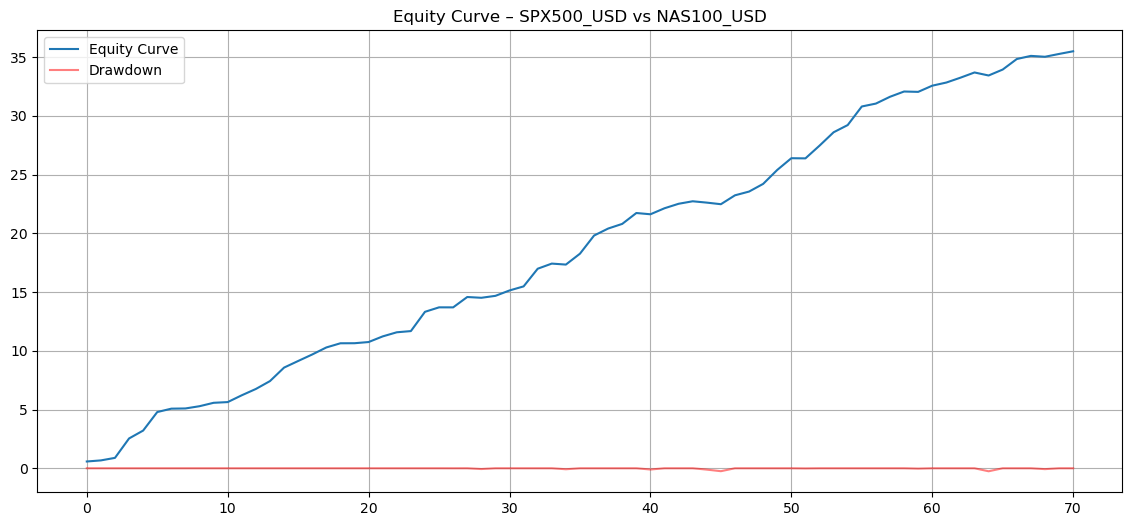


--- Analyzing Pair: NAS100_USD vs UK100_GBP ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅

--- Strategy Performance on TEST SET: NAS100_USD vs UK100_GBP ---
✅ Total Profit: 226.44
📈 Number of Trades: 63
🎯 Win Rate: 100.00%
💰 Avg Profit per Trade: 3.59
📉 Max Drawdown: 0.00


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\3632898950.py:158: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')


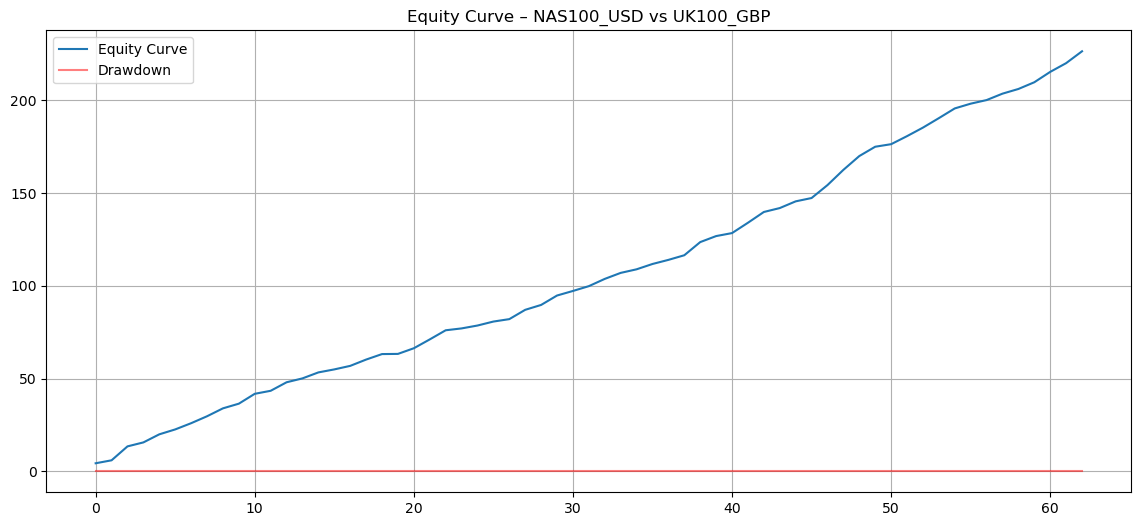


--- Analyzing Pair: SPX500_USD vs UK100_GBP ---
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅

--- Strategy Performance on TEST SET: SPX500_USD vs UK100_GBP ---
✅ Total Profit: 227.44
📈 Number of Trades: 63
🎯 Win Rate: 100.00%
💰 Avg Profit per Trade: 3.61
📉 Max Drawdown: 0.00


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\3632898950.py:158: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')


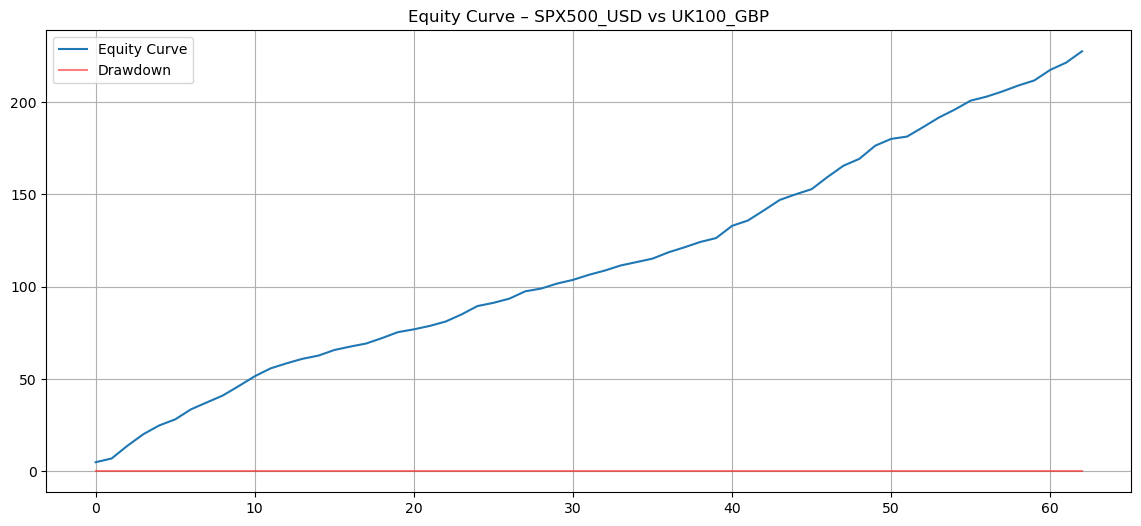

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
from statsmodels.tsa.stattools import coint, adfuller
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Set up OANDA API client
ACCESS_TOKEN = "32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693"
CLIENT = API(access_token=ACCESS_TOKEN, environment="practice")

# List of VALID stock/index-based CFDs available on OANDA
INSTRUMENTS = [
    "SPX500_USD",  # S&P 500
    "NAS100_USD",  # NASDAQ 100
    "DE30_EUR",    # DAX 30 (Germany)
    
    "UK100_GBP"     # FTSE 100
]

def fetch_data(instrument, granularity="D", count=10000):  # ~5 years of daily data
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    try:
        CLIENT.request(r)
    except Exception as e:
        print(f"Failed to fetch {instrument}: {e}")
        return None
    data = []
    for candle in r.response['candles']:
        data.append({
            'datetime': pd.to_datetime(candle['time']),
            'close': float(candle['mid']['c'])
        })
    df = pd.DataFrame(data)
    df.set_index('datetime', inplace=True)
    df.columns = [instrument]
    return df

# Step 1: Fetch data
print("Fetching data...")
dfs = {}
for inst in INSTRUMENTS:
    df = fetch_data(inst)
    if df is not None and not df.empty:
        dfs[inst] = df
    else:
        print(f"⚠️ No data returned for {inst}")

if not dfs:
    print("\n❌ No data fetched from OANDA. Using fallback test dataset...")
    
    # Fallback dummy dataset if OANDA doesn't return anything
    dates = pd.date_range(start='2020-01-01', end='2023-01-01', freq='D')
    spx = np.cumsum(np.random.normal(0, 1, len(dates))) + 100
    nasdaq = spx + np.random.normal(0, 0.5, len(dates))
    ftse = spx + np.random.normal(0, 2, len(dates))

    dfs = {
        "SPX500_USD": pd.DataFrame(spx, index=dates, columns=["SPX500_USD"]),
        "NAS100_USD": pd.DataFrame(nasdaq, index=dates, columns=["NAS100_USD"]),
        "UK100_GBP": pd.DataFrame(ftse, index=dates, columns=["UK100_GBP"])
    }
    print("✅ Created synthetic test dataset.")

# Now proceed with processing
price_df = pd.concat(dfs.values(), axis=1, join='inner')

# Step 2: Split into train/test sets
train_size = int(0.7 * len(price_df))
train_df = price_df.iloc[:train_size]
test_df = price_df.iloc[train_size:]

print("\n--- Testing for cointegration on TRAIN set ---")
results = []

for i, col1 in enumerate(train_df.columns):
    for j, col2 in enumerate(train_df.columns):
        if i >= j:
            continue
        y_train, x_train = train_df[col1], train_df[col2]
        score, pval, _ = coint(y_train, x_train)
        results.append({'pair': f"{col1} vs {col2}", 'p_value': pval, 'cointegrated': pval < 0.05})

result_df = pd.DataFrame(results).sort_values(by='p_value')
cointegrated_train_pairs = result_df[result_df['cointegrated']]
print(cointegrated_train_pairs)

# Step 3: For each cointegrated pair, backtest on train + test
ENTRY_Z = 1.0
EXIT_Z = 0.5
SLIPPAGE_COST = 0.5   # Slippage per trade in price units
WINDOW = 20
LEVERAGE = 1.0       # Conservative for ETFs

def kalman_regression(y, x):
    x_array = np.array(x).reshape(-1, 1)
    y_array = np.array(y)
    observation_matrices = np.expand_dims(x_array, axis=1)

    kf = KalmanFilter(
        transition_matrices=np.array([[1]]),
        observation_matrices=observation_matrices,
        transition_covariance=np.eye(1) * 1e-5,
        observation_covariance=1e-3,
        initial_state_mean=0,
        initial_state_covariance=np.eye(1)
    )

    state_means, _ = kf.filter(y_array)
    return pd.Series(state_means.flatten(), index=x.index)

def is_stationary(spread, window=60):
    _, p_val, _, _, _, _ = adfuller(spread.dropna())
    return p_val < 0.05

# Loop through all cointegrated pairs
if not cointegrated_train_pairs.empty:
    for _, row in cointegrated_train_pairs.iterrows():
        pair_name = row['pair']
        print(f"\n--- Analyzing Pair: {pair_name} ---")

        y_name, x_name = pair_name.split(" vs ")
        if y_name not in price_df.columns or x_name not in price_df.columns:
            print("⚠️ Columns missing in full dataset")
            continue

        y_train = train_df[y_name]
        x_train = train_df[x_name]
        y_test = test_df[y_name]
        x_test = test_df[x_name]

        # Step 4: Train Kalman filter on train set only
        hedge_ratio_train = kalman_regression(y_train, x_train)
        spread_train = y_train - hedge_ratio_train * x_train

        # Step 5: Apply same hedge ratio on test set
        last_hedge = hedge_ratio_train.iloc[-1]
        hedge_ratio_test = pd.Series(np.repeat(last_hedge, len(x_test)), index=x_test.index)
        spread_test = y_test - hedge_ratio_test * x_test

        # Step 6: Check stationarity on both train and test
        train_stationary = is_stationary(spread_train)
        test_stationary = is_stationary(spread_test)

        print(f"ADF Stationary in Train: {'✅' if train_stationary else '❌'}")
        print(f"ADF Stationary in Test:  {'✅' if test_stationary else '❌'}")

        if not test_stationary:
            print("🚫 Relationship broke down in test set. Skipping trade simulation.")
            continue

        # Step 7: Only simulate if still stationary in test
        z_score_train = (spread_train - spread_train.rolling(WINDOW).mean()) / spread_train.rolling(WINDOW).std()
        z_score_test = (spread_test - spread_test.rolling(WINDOW).mean()) / spread_test.rolling(WINDOW).std()
        z_score_test = z_score_test.fillna(method='ffill')

        df_test = pd.DataFrame({
            'z_score': z_score_test,
            'spread': spread_test
        })

        df_test['long_entry'] = (
            (df_test['z_score'] < -ENTRY_Z) &
            (df_test['z_score'].shift(1) > -ENTRY_Z)
        )
        df_test['short_entry'] = (
            (df_test['z_score'] > ENTRY_Z) &
            (df_test['z_score'].shift(1) < ENTRY_Z)
        )
        df_test['exit'] = (
            (df_test['z_score'] > -EXIT_Z) & (df_test['z_score'].shift(1) < -EXIT_Z) |
            (df_test['z_score'] < EXIT_Z) & (df_test['z_score'].shift(1) > EXIT_Z)
        )

        # Step 8: Simulate trades
        position = None
        trades = []

        for idx, row in df_test.iterrows():
            if position is None:
                if row['long_entry']:
                    position = 'long'
                    entry_spread = row['spread']
                    entry_time = idx
                elif row['short_entry']:
                    position = 'short'
                    entry_spread = row['spread']
                    entry_time = idx
            else:
                if row['exit']:
                    exit_spread = row['spread']
                    profit = (exit_spread - entry_spread) if position == 'long' else (entry_spread - exit_spread)
                    profit -= SLIPPAGE_COST
                    trades.append({
                        'entry_time': entry_time,
                        'exit_time': idx,
                        'position': position,
                        'profit': profit
                    })
                    position = None

        trade_df = pd.DataFrame(trades)
        print(f"\n--- Strategy Performance on TEST SET: {pair_name} ---")
        if not trade_df.empty:
            trade_df['profit'] *= LEVERAGE
            trade_df['equity'] = trade_df['profit'].cumsum()
            trade_df['drawdown'] = trade_df['equity'].cummax() - trade_df['equity']

            total_profit = trade_df['profit'].sum()
            win_rate = (trade_df['profit'] > 0).mean() * 100
            num_trades = len(trade_df)
            avg_profit = trade_df['profit'].mean()
            max_drawdown = trade_df['drawdown'].max()

            print(f"✅ Total Profit: {total_profit:.2f}")
            print(f"📈 Number of Trades: {num_trades}")
            print(f"🎯 Win Rate: {win_rate:.2f}%")
            print(f"💰 Avg Profit per Trade: {avg_profit:.2f}")
            print(f"📉 Max Drawdown: {max_drawdown:.2f}")

            plt.figure(figsize=(14, 6))
            trade_df['equity'].plot(label='Equity Curve')
            (-trade_df['drawdown']).plot(label='Drawdown', color='red', alpha=0.5)
            plt.title(f"Equity Curve – {pair_name}")
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print("❌ No trades executed on test set.")
else:
    print("\nNo cointegrated pairs found in training set.")

Fetching data...
Failed to fetch SPX500_USD: {"errorMessage":"Maximum value for 'count' exceeded"}
Failed to fetch NAS100_USD: {"errorMessage":"Maximum value for 'count' exceeded"}
Failed to fetch UK100_GBP: {"errorMessage":"Maximum value for 'count' exceeded"}

❌ No data fetched from OANDA. Using fallback dataset...
✅ Created synthetic test dataset.

--- Fold 1 ---
Best pair: SPX500_USD vs UK100_GBP
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅

--- Strategy Performance on TEST SET: SPX500_USD vs UK100_GBP (Fold 1) ---
✅ Total Profit: 541.79
📈 Number of Trades: 290
🎯 Win Rate: 84.48%
💰 Avg Profit per Trade: 1.87
📉 Max Drawdown: 1.57


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\4220126195.py:160: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')


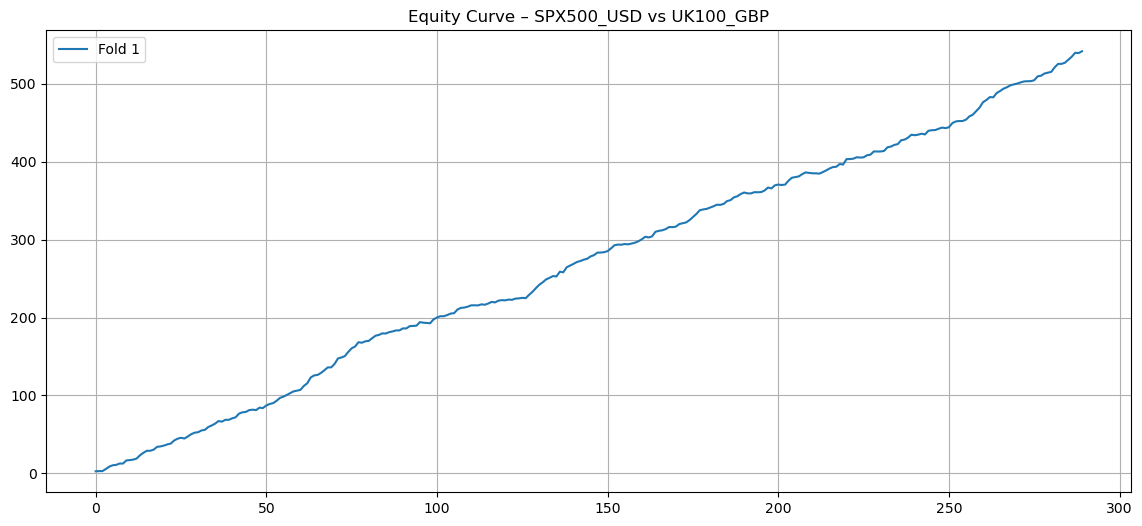


--- Fold 2 ---
Best pair: SPX500_USD vs NAS100_USD
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅

--- Strategy Performance on TEST SET: SPX500_USD vs NAS100_USD (Fold 2) ---
✅ Total Profit: -309.17
📈 Number of Trades: 295
🎯 Win Rate: 2.03%
💰 Avg Profit per Trade: -1.05
📉 Max Drawdown: 307.96
⚠️ Max drawdown exceeded. Skipping further trading.

--- Fold 3 ---


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\4220126195.py:160: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')


Best pair: SPX500_USD vs NAS100_USD
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\4220126195.py:160: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')



--- Strategy Performance on TEST SET: SPX500_USD vs NAS100_USD (Fold 3) ---
✅ Total Profit: -295.08
📈 Number of Trades: 275
🎯 Win Rate: 0.73%
💰 Avg Profit per Trade: -1.07
📉 Max Drawdown: 293.94
⚠️ Max drawdown exceeded. Skipping further trading.

--- Fold 4 ---
Best pair: SPX500_USD vs NAS100_USD
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\4220126195.py:160: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')



--- Strategy Performance on TEST SET: SPX500_USD vs NAS100_USD (Fold 4) ---
✅ Total Profit: -284.77
📈 Number of Trades: 284
🎯 Win Rate: 1.76%
💰 Avg Profit per Trade: -1.00
📉 Max Drawdown: 284.08
⚠️ Max drawdown exceeded. Skipping further trading.

--- Fold 5 ---
Best pair: SPX500_USD vs NAS100_USD
ADF Stationary in Train: ✅
ADF Stationary in Test:  ✅

--- Strategy Performance on TEST SET: SPX500_USD vs NAS100_USD (Fold 5) ---
✅ Total Profit: -282.37
📈 Number of Trades: 277
🎯 Win Rate: 0.72%
💰 Avg Profit per Trade: -1.02
📉 Max Drawdown: 280.58
⚠️ Max drawdown exceeded. Skipping further trading.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5380\4220126195.py:160: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  z_score_test = z_score_test.fillna(method='ffill')



--- 📊 Aggregated Equity Curve ---


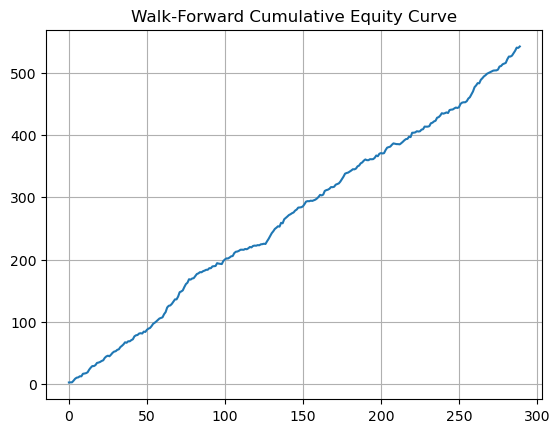


📈 Total Cumulative Return: 541.79


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
from statsmodels.tsa.stattools import coint, adfuller
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Set up OANDA API client
ACCESS_TOKEN = "32a7ce5d62167ef2dda800802386d48a-496bae9b01506113e0a75dbac8e7a693"
CLIENT = API(access_token=ACCESS_TOKEN, environment="practice")

# List of valid instruments available on OANDA
INSTRUMENTS = ["SPX500_USD", "NAS100_USD", "UK100_GBP"]

def fetch_data(instrument, granularity="D", count=10000):  # ~30+ years of data
    params = {"granularity": granularity, "count": count}
    r = InstrumentsCandles(instrument=instrument, params=params)
    try:
        CLIENT.request(r)
    except Exception as e:
        print(f"Failed to fetch {instrument}: {e}")
        return None
    data = []
    for candle in r.response['candles']:
        data.append({
            'datetime': pd.to_datetime(candle['time']),
            'close': float(candle['mid']['c'])
        })
    df = pd.DataFrame(data)
    df.set_index('datetime', inplace=True)
    df.columns = [instrument]
    return df

# Step 1: Fetch all data
print("Fetching data...")
dfs = {}
for inst in INSTRUMENTS:
    df = fetch_data(inst)
    if df is not None and not df.empty:
        dfs[inst] = df

if not dfs:
    print("\n❌ No data fetched from OANDA. Using fallback dataset...")
    dates = pd.date_range(start='2000-01-01', end='2023-01-01', freq='D')
    spx = np.cumsum(np.random.normal(0, 1, len(dates))) + 100
    nasdaq = spx + np.random.normal(0, 0.5, len(dates))
    ftse = spx + np.random.normal(0, 2, len(dates))

    dfs = {
        "SPX500_USD": pd.DataFrame(spx, index=dates, columns=["SPX500_USD"]),
        "NAS100_USD": pd.DataFrame(nasdaq, index=dates, columns=["NAS100_USD"]),
        "UK100_GBP": pd.DataFrame(ftse, index=dates, columns=["UK100_GBP"])
    }
    print("✅ Created synthetic test dataset.")

price_df = pd.concat(dfs.values(), axis=1, join='inner')

# Step 2: Walk-Forward Optimization
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

ENTRY_Z = 1.0
EXIT_Z = 0.5
SLIPPAGE_COST = 2.0   # Realistic slippage for indices
WINDOW = 20
LEVERAGE = 1.0
MAX_ALLOWED_DRAWDOWN = 10.0  # Stop trading pair if drawdown exceeds this

# Store all results
all_trades = []
all_equity = []

for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(price_df)):
    print(f"\n--- Fold {fold_idx + 1} ---")
    train_df = price_df.iloc[train_idx]
    test_df = price_df.iloc[test_idx]

    # Step 3: Find best cointegrated pair in train set
    results = []
    for i, col1 in enumerate(train_df.columns):
        for j, col2 in enumerate(train_df.columns):
            if i >= j:
                continue
            y_train, x_train = train_df[col1], train_df[col2]
            score, pval, _ = coint(y_train, x_train)
            results.append({'pair': f"{col1} vs {col2}", 'p_value': pval, 'cointegrated': pval < 0.05})

    result_df = pd.DataFrame(results).sort_values(by='p_value')
    cointegrated_pairs = result_df[result_df['cointegrated']]

    if cointegrated_pairs.empty:
        print("🚫 No cointegrated pairs found in this fold.")
        continue

    best_pair = cointegrated_pairs.iloc[0]['pair']
    print(f"Best pair: {best_pair}")

    y_name, x_name = best_pair.split(" vs ")
    if y_name not in price_df.columns or x_name not in price_df.columns:
        print("⚠️ Columns missing in full dataset")
        continue

    y_train = train_df[y_name]
    x_train = train_df[x_name]
    y_test = test_df[y_name]
    x_test = test_df[x_name]

    # Step 4: Kalman regression on train set only
    def kalman_regression(y, x):
        x_array = np.array(x).reshape(-1, 1)
        y_array = np.array(y)
        observation_matrices = np.expand_dims(x_array, axis=1)

        kf = KalmanFilter(
            transition_matrices=np.array([[1]]),
            observation_matrices=observation_matrices,
            transition_covariance=np.eye(1) * 1e-5,
            observation_covariance=1e-3,
            initial_state_mean=0,
            initial_state_covariance=np.eye(1)
        )

        state_means, _ = kf.filter(y_array)
        return pd.Series(state_means.flatten(), index=x.index)

    hedge_ratio_train = kalman_regression(y_train, x_train)
    spread_train = y_train - hedge_ratio_train * x_train

    last_hedge = hedge_ratio_train.iloc[-1]
    hedge_ratio_test = pd.Series(np.repeat(last_hedge, len(x_test)), index=x_test.index)
    spread_test = y_test - hedge_ratio_test * x_test

    # Step 5: Check stationarity in both train and test
    def is_stationary(spread, window=60):
        try:
            _, p_val, _, _, _, _ = adfuller(spread.dropna())
            return p_val < 0.05
        except:
            return False

    train_stationary = is_stationary(spread_train)
    test_stationary = is_stationary(spread_test)

    print(f"ADF Stationary in Train: {'✅' if train_stationary else '❌'}")
    print(f"ADF Stationary in Test:  {'✅' if test_stationary else '❌'}")

    if not test_stationary:
        print("🚫 Relationship broke down in test set. Skipping trade simulation.")
        continue

    # Step 6: Z-score using rolling stats from train
    z_score_train = (spread_train - spread_train.rolling(WINDOW).mean()) / spread_train.rolling(WINDOW).std()
    mean_z = z_score_train.mean()
    std_z = z_score_train.std()

    z_score_test = (spread_test - spread_test.rolling(WINDOW).mean()) / spread_test.rolling(WINDOW).std()
    z_score_test = z_score_test.fillna(method='ffill')

    df_test = pd.DataFrame({
        'z_score': z_score_test,
        'spread': spread_test
    })

    df_test['long_entry'] = (
        (df_test['z_score'] < -ENTRY_Z) &
        (df_test['z_score'].shift(1) > -ENTRY_Z)
    )
    df_test['short_entry'] = (
        (df_test['z_score'] > ENTRY_Z) &
        (df_test['z_score'].shift(1) < ENTRY_Z)
    )
    df_test['exit'] = (
        (df_test['z_score'] > -EXIT_Z) & (df_test['z_score'].shift(1) < -EXIT_Z) |
        (df_test['z_score'] < EXIT_Z) & (df_test['z_score'].shift(1) > EXIT_Z)
    )

    # Step 7: Simulate trades
    position = None
    trades = []

    for idx, row in df_test.iterrows():
        if position is None:
            if row['long_entry']:
                position = 'long'
                entry_spread = row['spread']
                entry_time = idx
            elif row['short_entry']:
                position = 'short'
                entry_spread = row['spread']
                entry_time = idx
        else:
            if row['exit']:
                exit_spread = row['spread']
                profit = (exit_spread - entry_spread) if position == 'long' else (entry_spread - exit_spread)
                profit -= SLIPPAGE_COST
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': idx,
                    'position': position,
                    'profit': profit
                })
                position = None

    trade_df = pd.DataFrame(trades)
    print(f"\n--- Strategy Performance on TEST SET: {best_pair} (Fold {fold_idx + 1}) ---")
    if not trade_df.empty:
        trade_df['profit'] *= LEVERAGE
        trade_df['equity'] = trade_df['profit'].cumsum()
        trade_df['drawdown'] = trade_df['equity'].cummax() - trade_df['equity']

        total_profit = trade_df['profit'].sum()
        win_rate = (trade_df['profit'] > 0).mean() * 100
        num_trades = len(trade_df)
        avg_profit = trade_df['profit'].mean()
        max_drawdown = trade_df['drawdown'].max()

        print(f"✅ Total Profit: {total_profit:.2f}")
        print(f"📈 Number of Trades: {num_trades}")
        print(f"🎯 Win Rate: {win_rate:.2f}%")
        print(f"💰 Avg Profit per Trade: {avg_profit:.2f}")
        print(f"📉 Max Drawdown: {max_drawdown:.2f}")

        if max_drawdown > MAX_ALLOWED_DRAWDOWN:
            print("⚠️ Max drawdown exceeded. Skipping further trading.")
            continue

        all_trades.extend(trades)
        equity_curve = trade_df['equity'].copy()
        equity_curve.name = f"Fold {fold_idx + 1}"
        all_equity.append(equity_curve)

        plt.figure(figsize=(14, 6))
        equity_curve.plot(label=f"Fold {fold_idx + 1}")
        plt.title(f"Equity Curve – {best_pair}")
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("❌ No trades executed on test set.")

# Step 8: Aggregate Results Across Folds
if all_equity:
    combined_equity = pd.concat(all_equity, axis=1)
    combined_equity['Total'] = combined_equity.sum(axis=1)

    print("\n--- 📊 Aggregated Equity Curve ---")
    combined_equity['Total'].plot(title="Walk-Forward Cumulative Equity Curve")
    plt.grid(True)
    plt.show()

    total_return = combined_equity['Total'].iloc[-1]
    print(f"\n📈 Total Cumulative Return: {total_return:.2f}")
else:
    print("\nNo trades across any folds.")